In [23]:
import os
import sys

module_path = os.path.abspath(os.path.join("..", ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [24]:
import math
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

from typing import Literal
from pathlib import Path

from src.prototypes.torch_apk_analysis_model_io import (
    load_apk_analysis_model_metadata,
)

from src.prototypes.ml_model_io import (
    load_ml_model_from_version,
    load_ml_version_metadata,
    load_ml_model_metadata,
)

%matplotlib inline

In [25]:
SEQUENCE_COLS = [
    "activities_list",
    "services_list",
    "receivers_list",
    "permissions_list",
    "api_calls_list",
]
CHAR_COLS = ["fuzzy_hash"]
VECTOR_COLS = ["opcode_counts"]
SCALAR_COLS = ["file_size"]

PROJECT_ROOT = Path().cwd().parent.parent
PATH_TO_SAVE_DIR = PROJECT_ROOT / "plots" / "test"
PATH_TO_SAVE_NN_MODEL = PROJECT_ROOT / "model_artifacts" / "nn_models"
PATH_TO_SAVE_ML_MODEL = PROJECT_ROOT / "model_artifacts" / "ml_models"

NN_MODEL_VERSION = None
ML_MODELS_VERSION = None

# Load the latest nn model metadata
nn_metadata = load_apk_analysis_model_metadata(version=NN_MODEL_VERSION, base_dir=PATH_TO_SAVE_NN_MODEL)
nn_all_metrics = nn_metadata["all_metrics"]

# Load the latest classical ml models metadata
ml_metadata = load_ml_version_metadata(version=ML_MODELS_VERSION, base_dir=PATH_TO_SAVE_ML_MODEL)
ml_all_metrics = {
    name: load_ml_model_metadata(name, version=ML_MODELS_VERSION, base_dir=PATH_TO_SAVE_ML_MODEL)["all_metrics"]
    for name in ml_metadata["models"].keys()
}

Loading latest model version: 20250702_162411
Loading latest model version: 20250702_162653
Loading latest model version: 20250702_162653
Loading latest model version: 20250702_162653
Loading latest model version: 20250702_162653
Loading latest model version: 20250702_162653
Loading latest model version: 20250702_162653


In [26]:
nn_all_metrics

{'accuracy': [0.9835317681094915,
  0.9793034382997663,
  0.9793034382997663,
  0.9824190497385111,
  0.9794147101368643,
  0.9808612440191388,
  0.981751418715923,
  0.977856904417492,
  0.9810837876933348,
  0.9836430399465895],
 'precision': [0.9878569822352148,
  0.9803439803439803,
  0.9833670487750056,
  0.9802529398713113,
  0.9760956175298805,
  0.9836359560636628,
  0.9849674669059906,
  0.9831004957187922,
  0.9823463687150839,
  0.9813664596273292],
 'recall': [0.9790505905950524,
  0.9781591263650546,
  0.9750390015600624,
  0.9846222420325385,
  0.982839313572543,
  0.9779362603075552,
  0.9783819924225541,
  0.972364608870069,
  0.9797191887675507,
  0.9859594383775351],
 'f1': [0.9834340720841728,
  0.9792503346720214,
  0.9791853178155775,
  0.9824327329330665,
  0.9794558578567463,
  0.9807778274474743,
  0.9816636851520573,
  0.9777030812324929,
  0.981031019861638,
  0.9836575875486381],
 'roc_auc': [0.998003838248768,
  0.9970366490850111,
  0.9964852536958622,
  0.

Plot saved to c:\Users\david\Desktop\Clase\TFG\tfg_24_25\plots\test\cv_distributions\accuracy_cv_distribution.svg


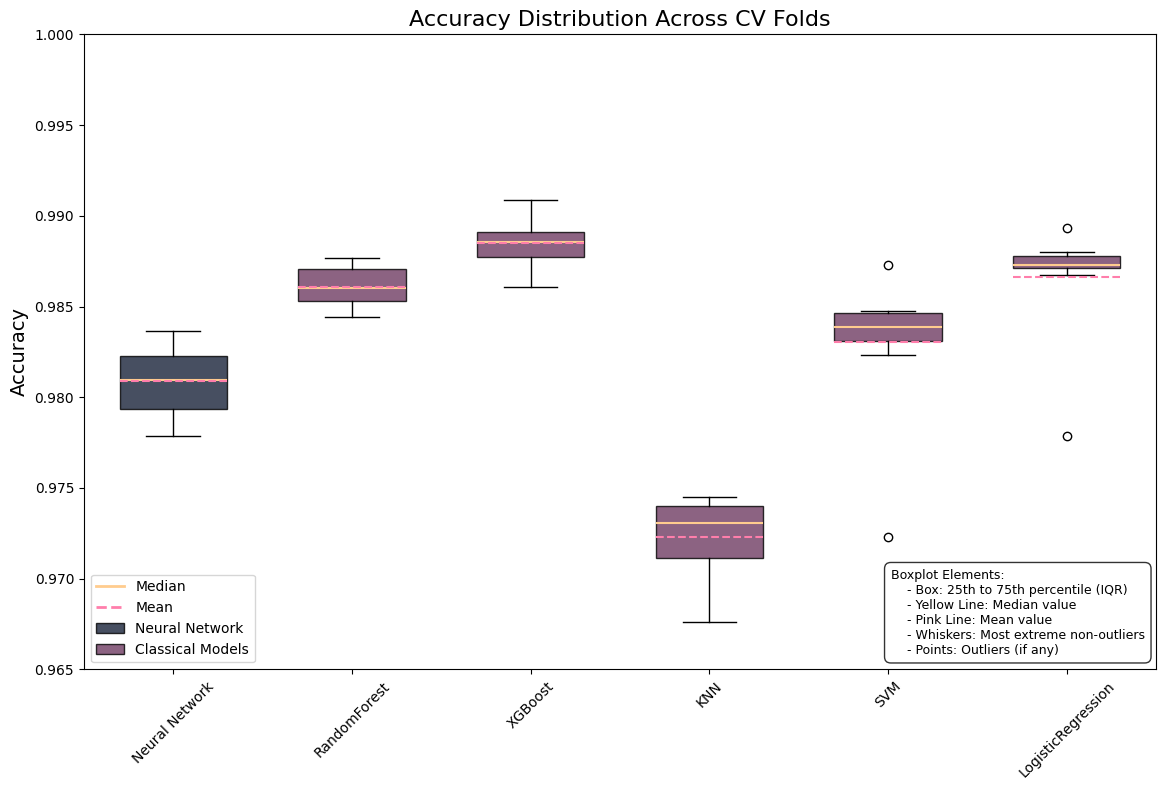

Plot saved to c:\Users\david\Desktop\Clase\TFG\tfg_24_25\plots\test\cv_distributions\recall_cv_distribution.svg


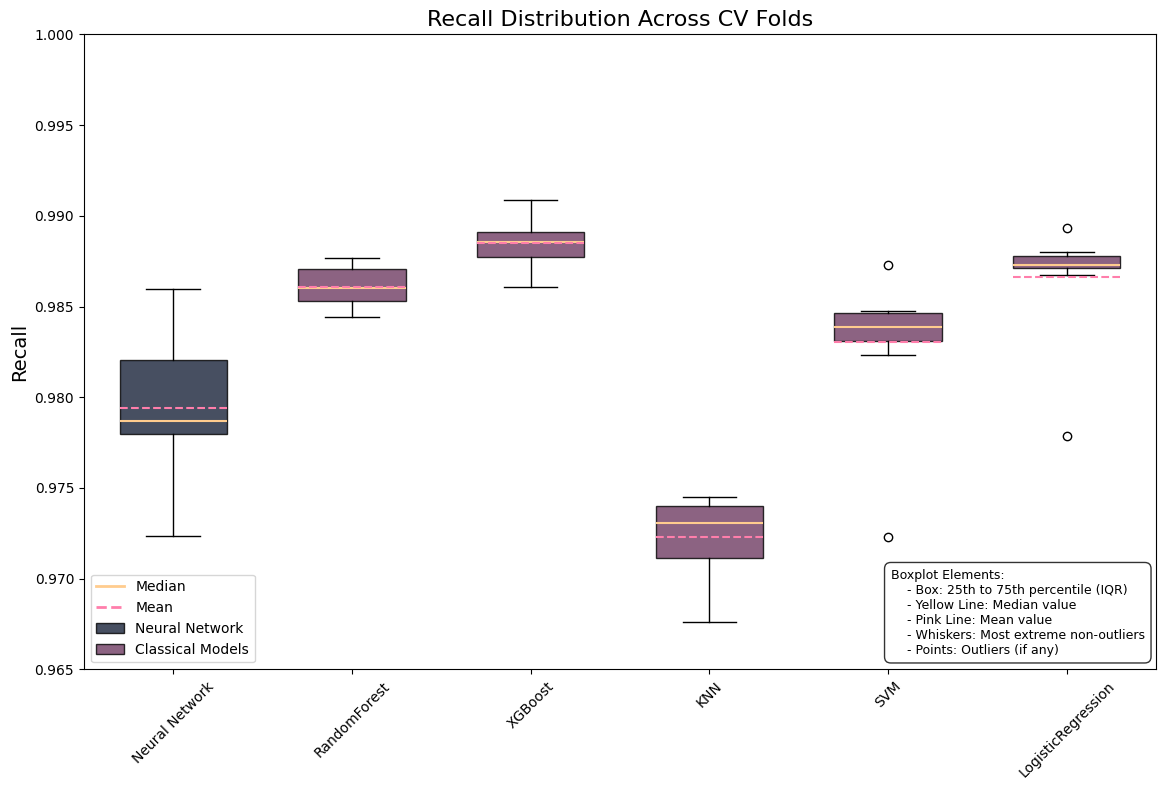

Plot saved to c:\Users\david\Desktop\Clase\TFG\tfg_24_25\plots\test\cv_distributions\precision_cv_distribution.svg


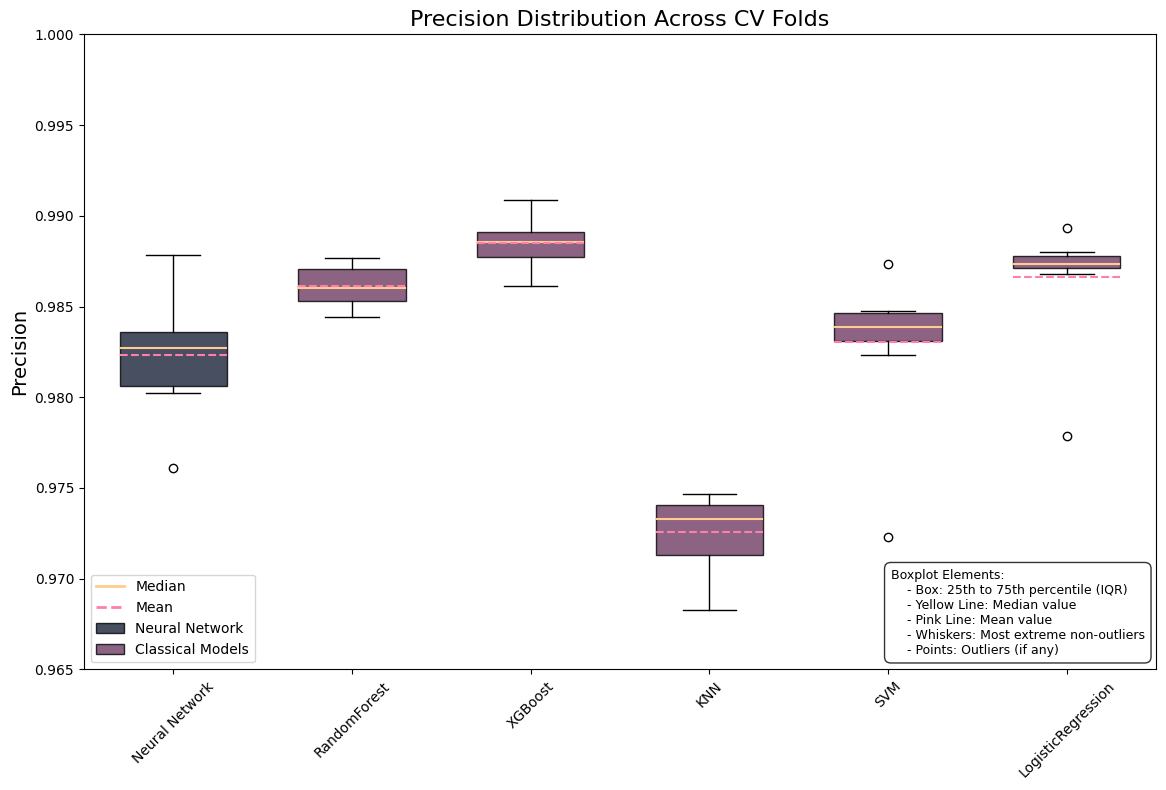

Plot saved to c:\Users\david\Desktop\Clase\TFG\tfg_24_25\plots\test\cv_distributions\f1_cv_distribution.svg


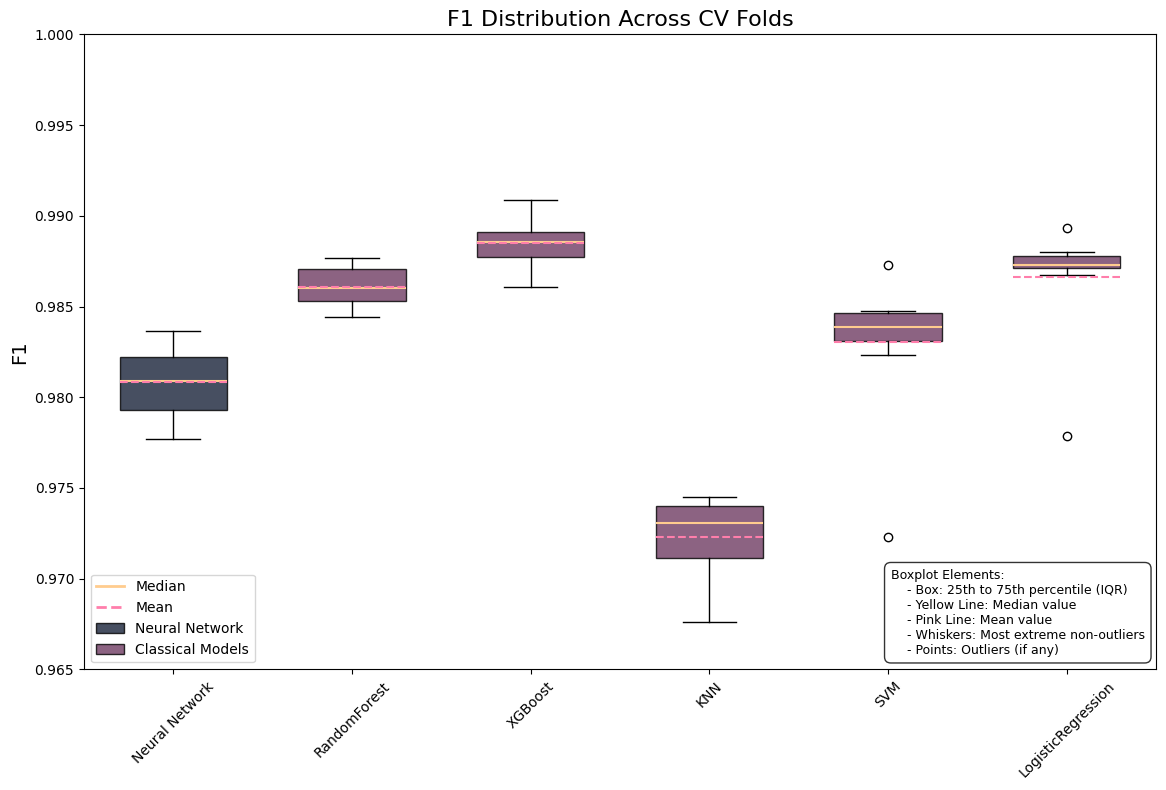

Plot saved to c:\Users\david\Desktop\Clase\TFG\tfg_24_25\plots\test\cv_distributions\roc_auc_cv_distribution.svg


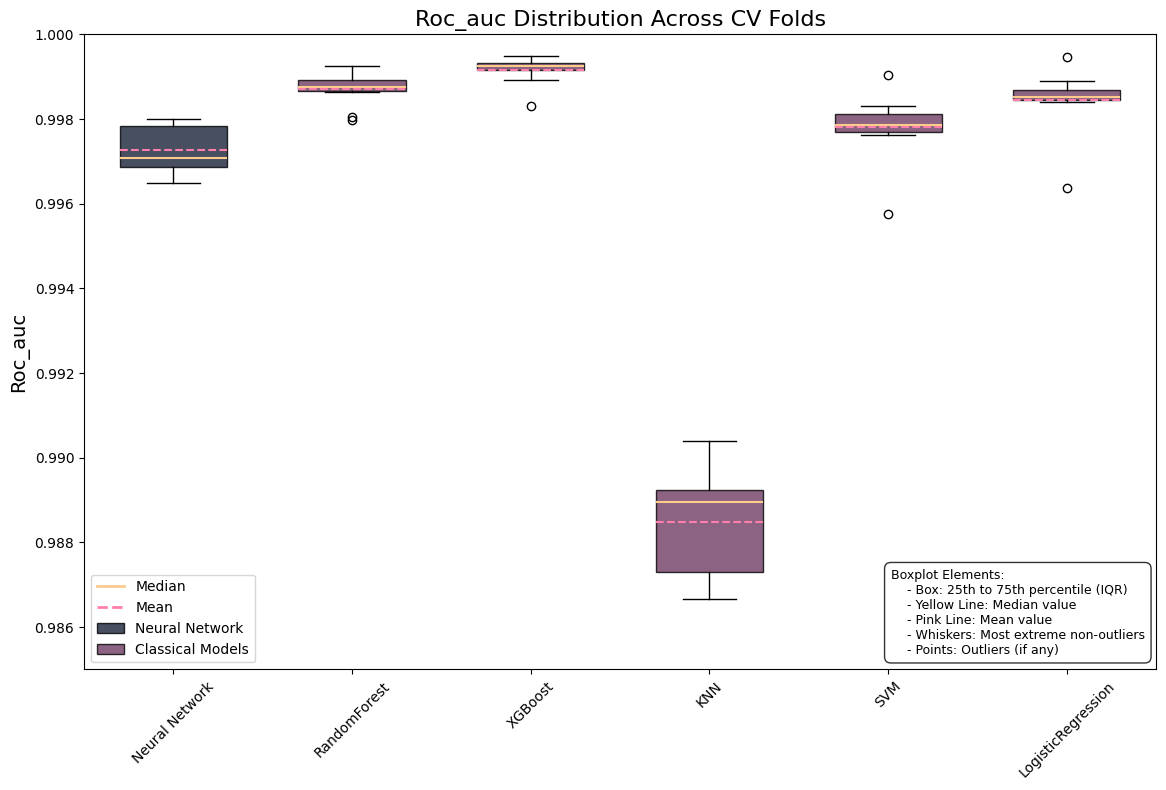

Plot saved to c:\Users\david\Desktop\Clase\TFG\tfg_24_25\plots\test\cv_distributions\pr_auc_cv_distribution.svg


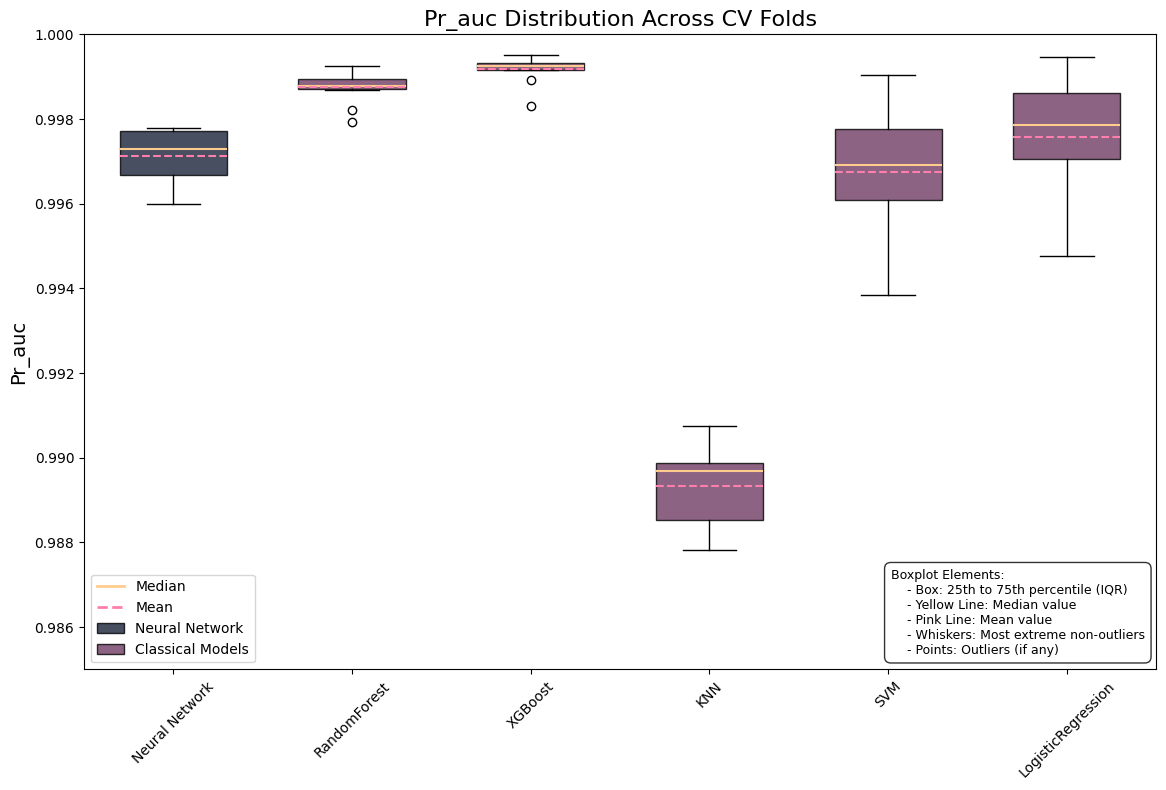

In [27]:
# Visualize score distribution across CV folds
def plot_cv_distribution(
    nn_results,
    classic_results,
    metric_to_plot: Literal[
        "accuracy", "precision", "recall", "f1", "pr_auc", "roc_auc"
    ] = "recall",
    save_dir: Path | str | None = None,
):
    plt.figure(figsize=(12, 8))

    # Add neural network results
    nn_recall = nn_results[metric_to_plot]
    plt.boxplot(
        [nn_recall],
        positions=[0],
        widths=0.6,
        patch_artist=True,
        showmeans=True,
        meanline=True,
        boxprops=dict(facecolor="#192339", alpha=0.8),
        medianprops=dict(color="#ffcc8e", lw=1.5),
        meanprops=dict(color="#ff7eab", lw=1.5),
    )

    # Add classical model results
    classic_positions = list(range(1, len(classic_results) + 1))
    classic_recall = [results[metric_to_plot] for results in classic_results.values()]
    plt.boxplot(
        classic_recall,
        positions=classic_positions,
        widths=0.6,
        patch_artist=True,
        showmeans=True,
        meanline=True,
        boxprops=dict(facecolor="#6f3c63", alpha=0.8),
        medianprops=dict(color="#ffcc8e", lw=1.5),
        meanprops=dict(color="#ff7eab", lw=1.5),
    )

    # Set labels
    metric_name = metric_to_plot.capitalize()
    model_names = ["Neural Network"] + list(classic_results.keys())
    plt.xticks(range(len(model_names)), model_names, rotation=45)
    plt.ylabel(metric_name, fontsize=14)
    plt.title(f"{metric_name} Distribution Across CV Folds", fontsize=16)

    # Add legend/explanation for boxplot elements
    legend_elements = [
        Line2D([0], [0], color="#ffcc8e", lw=2, label="Median"),
        Line2D([0], [0], color="#ff7eab", lw=2, linestyle="--", label="Mean"),
        Rectangle(
            (0, 0), 1, 1, fc="#192339", alpha=0.8, edgecolor="black", label="Neural Network"
        ),
        Rectangle(
            (0, 0), 1, 1, fc="#6f3c63", alpha=0.8, edgecolor="black", label="Classical Models"
        ),
    ]

    # Add the legend for colors in the upper right corner of the axis
    plt.legend(handles=legend_elements, loc="lower left")
    
    if metric_to_plot not in ["pr_auc", "roc_auc"]:
        plt.ylim(0.965, 1)
    else:
        plt.ylim(0.985, 1)
    
    # Create explanation text for boxplot components
    explanation = """Boxplot Elements:
    - Box: 25th to 75th percentile (IQR)
    - Yellow Line: Median value
    - Pink Line: Mean value
    - Whiskers: Most extreme non-outliers
    - Points: Outliers (if any)"""

    # Add explanation text as a text box inside the plot
    # Get the current axis
    ax = plt.gca()
    # Position in axis coordinates (0,0 is bottom left, 1,1 is top right)
    # You may need to adjust these values based on your specific plot
    ax.text(
        0.7525,
        0.02,
        explanation,
        transform=ax.transAxes,
        fontsize=9,
        verticalalignment="bottom",
        bbox=dict(facecolor="white", alpha=0.8, boxstyle="round,pad=0.5"),
    )

    plt.tight_layout()

    if save_dir:
        base_dir = os.path.join(save_dir, "cv_distributions")
        full_path = os.path.join(base_dir, f"{metric_to_plot}_cv_distribution.svg")

        os.makedirs(base_dir, exist_ok=True)
        plt.savefig(full_path, format="svg", dpi=300, bbox_inches="tight")
        print(f"Plot saved to {full_path}")

    plt.show()


metrics_to_plot = ["accuracy", "recall", "precision", "f1", "roc_auc", "pr_auc"]

for metric in metrics_to_plot:
    plot_cv_distribution(
        nn_all_metrics, ml_all_metrics, metric, save_dir=PATH_TO_SAVE_DIR
    )

Combined CV boxplots saved to c:\Users\david\Desktop\Clase\TFG\tfg_24_25\plots\test\all_cv_distributions.svg


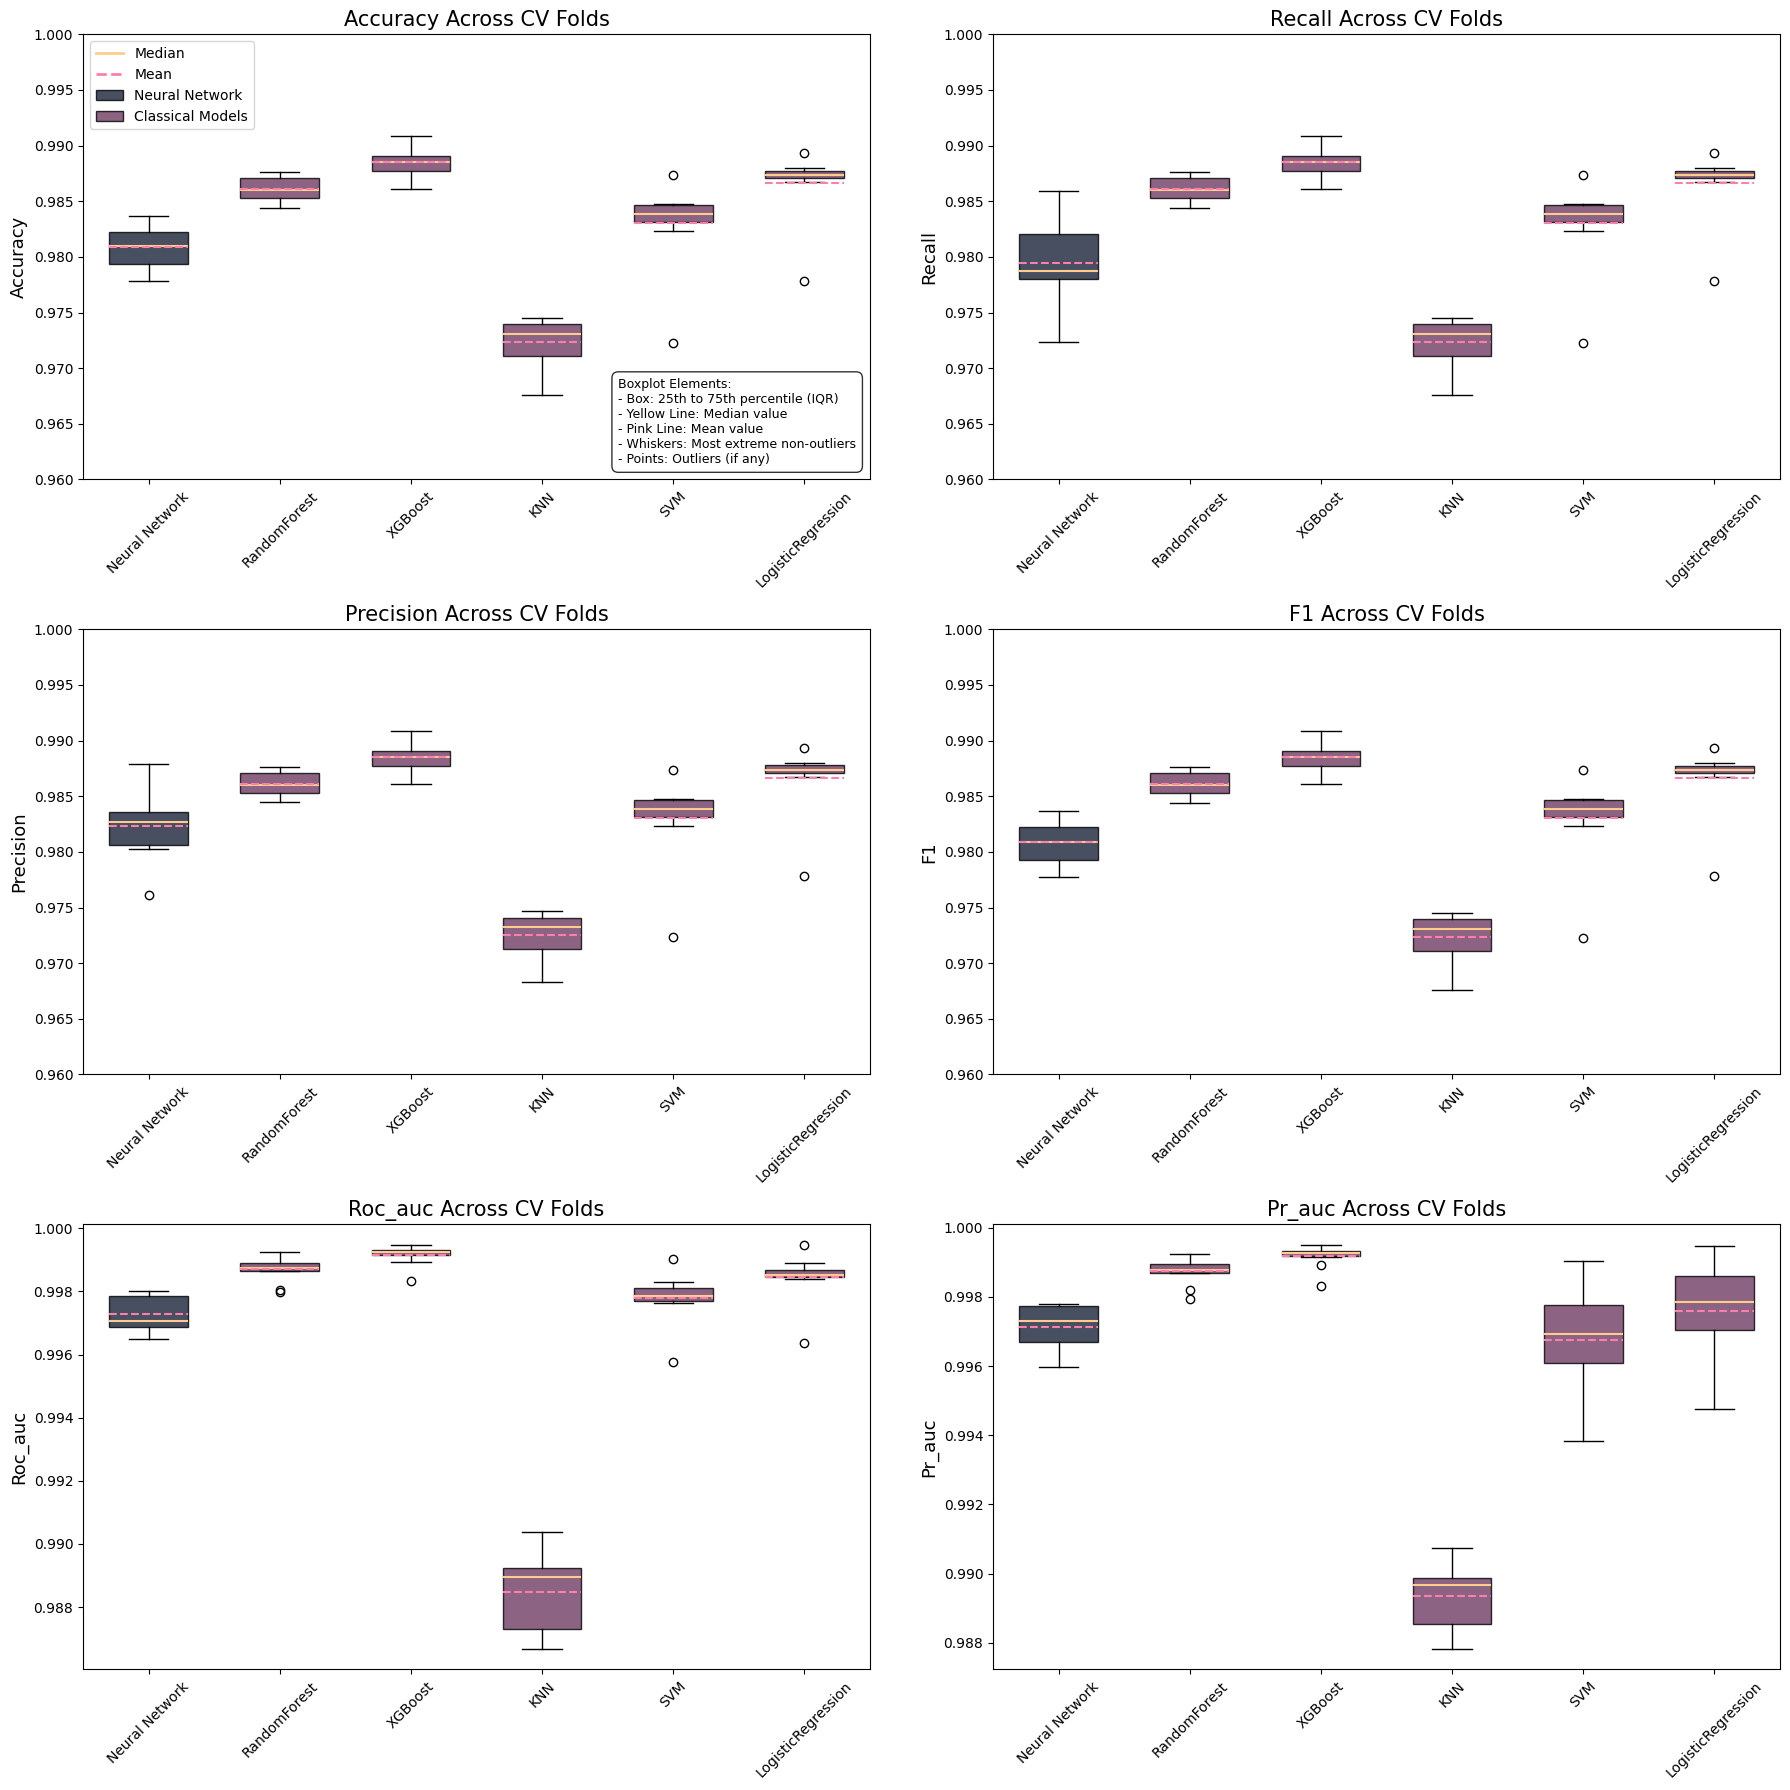

In [28]:
def plot_all_cv_distributions(
    nn_results,
    classic_results,
    metrics=("accuracy", "recall", "precision", "f1", "roc_auc", "pr_auc"),
    save_path=None
):
    fig, axes = plt.subplots(3, 2, figsize=(18, 18))
    axes = axes.flatten()

    for idx, metric_to_plot in enumerate(metrics):
        ax = axes[idx]
        # NN results
        nn_metric = nn_results[metric_to_plot]
        ax.boxplot(
            [nn_metric],
            positions=[0],
            widths=0.6,
            patch_artist=True,
            showmeans=True,
            meanline=True,
            boxprops=dict(facecolor="#192339", alpha=0.8),
            medianprops=dict(color="#ffcc8e", lw=1.5),
            meanprops=dict(color="#ff7eab", lw=1.5),
        )
        # Classical models
        classic_positions = list(range(1, len(classic_results) + 1))
        classic_metric = [results[metric_to_plot] for results in classic_results.values()]
        ax.boxplot(
            classic_metric,
            positions=classic_positions,
            widths=0.6,
            patch_artist=True,
            showmeans=True,
            meanline=True,
            boxprops=dict(facecolor="#6f3c63", alpha=0.8),
            medianprops=dict(color="#ffcc8e", lw=1.5),
            meanprops=dict(color="#ff7eab", lw=1.5),
        )
        if metric_to_plot not in ["pr_auc", "roc_auc"]:
            ax.set_ylim(0.960, 1)
        # else:
        #     ax.ylim(0.985, 1)
        
        # Labels
        metric_name = metric_to_plot.capitalize()
        model_names = ["Neural Network"] + list(classic_results.keys())
        ax.set_xticks(range(len(model_names)))
        ax.set_xticklabels(model_names, rotation=45)
        ax.set_ylabel(metric_name, fontsize=13)
        ax.set_title(f"{metric_name} Across CV Folds", fontsize=15)
            
        # Legend (only on first plot)
        if idx == 0:
            from matplotlib.patches import Rectangle
            from matplotlib.lines import Line2D
            legend_elements = [
                Line2D([0], [0], color="#ffcc8e", lw=2, label="Median"),
                Line2D([0], [0], color="#ff7eab", lw=2, linestyle="--", label="Mean"),
                Rectangle((0, 0), 1, 1, fc="#192339", alpha=0.8, edgecolor="black", label="Neural Network"),
                Rectangle((0, 0), 1, 1, fc="#6f3c63", alpha=0.8, edgecolor="black", label="Classical Models"),
            ]
            ax.legend(handles=legend_elements, loc="upper left", fontsize=10)
        # Explanation text (optional, only on first plot)
        if idx == 0:
            explanation = (
                "Boxplot Elements:\n"
                "- Box: 25th to 75th percentile (IQR)\n"
                "- Yellow Line: Median value\n"
                "- Pink Line: Mean value\n"
                "- Whiskers: Most extreme non-outliers\n"
                "- Points: Outliers (if any)"
            )
            ax.text(
                0.68, 0.03, explanation,
                transform=ax.transAxes,
                fontsize=9,
                verticalalignment="bottom",
                bbox=dict(facecolor="white", alpha=0.8, boxstyle="round,pad=0.5"),
            )

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format="svg", dpi=300, bbox_inches="tight")
        print(f"Combined CV boxplots saved to {save_path}")
    plt.show()

# Usage:
plot_all_cv_distributions(nn_all_metrics, ml_all_metrics, save_path=PATH_TO_SAVE_DIR / "all_cv_distributions.svg")

ROC and PR curves saved to c:\Users\david\Desktop\Clase\TFG\tfg_24_25\plots\test\roc_pr_curves.svg


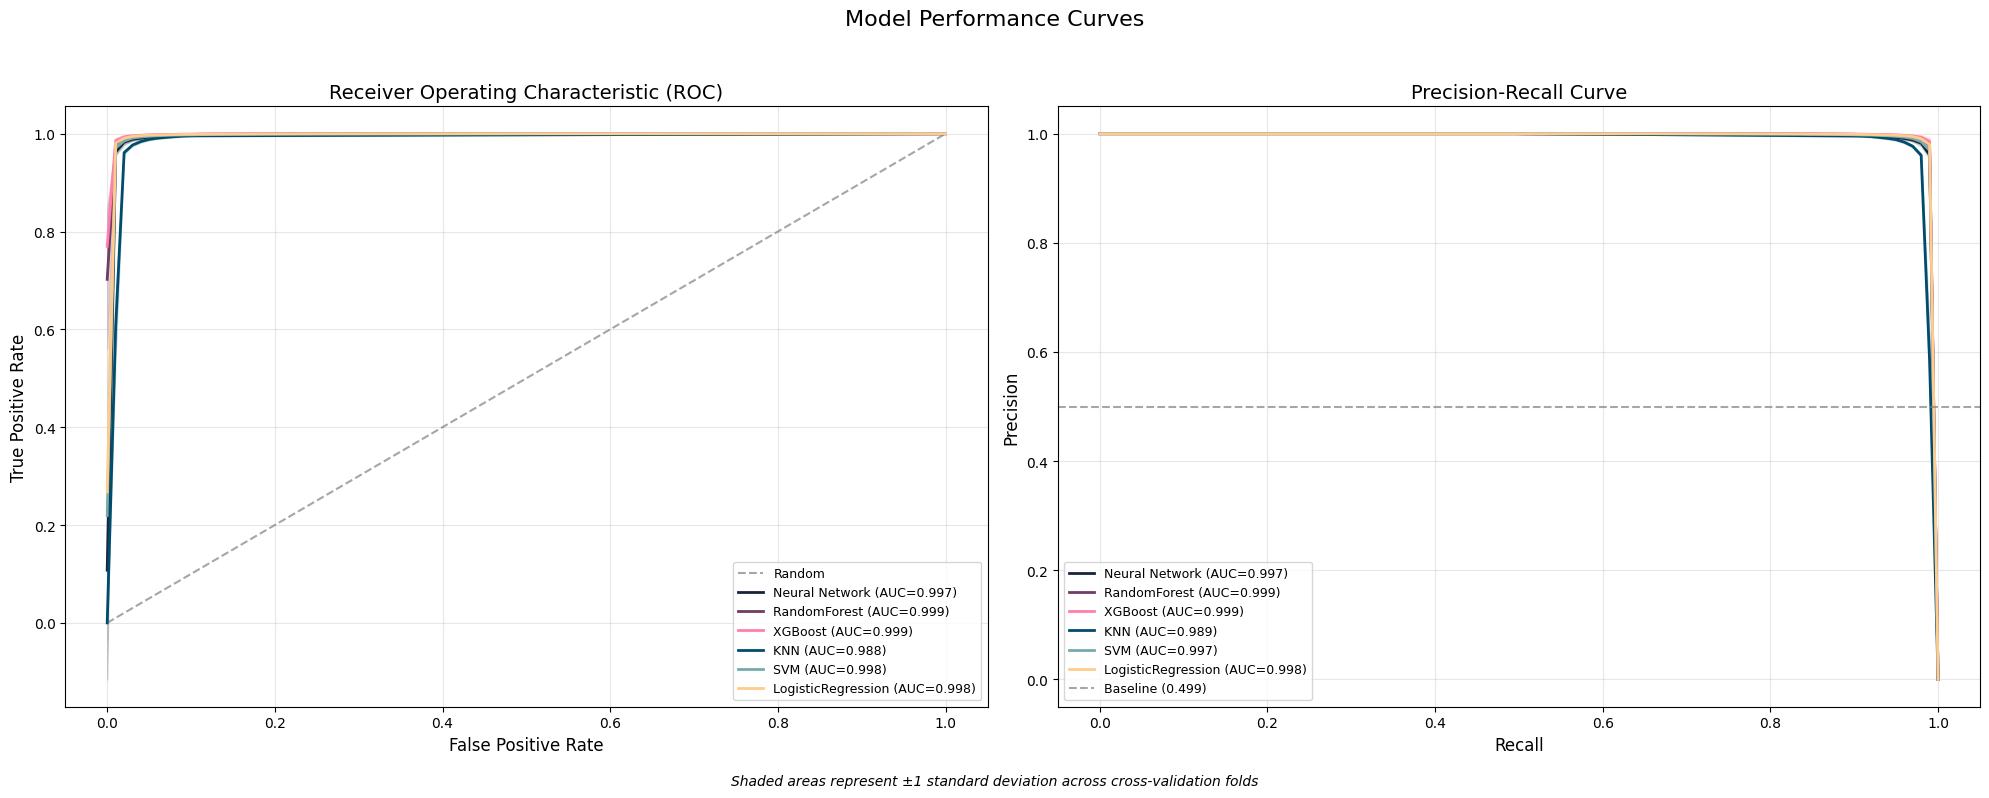

In [29]:
def plot_roc_pr_curves(
    results_nn, results_clf_dict, save_dir: Path | str | None = None
):
    """
    Overlays mean ROC and PR curves with ± std shading in a side-by-side layout.

    Parameters
    ----------
    results_nn : dict
        Neural network results containing 'roc_curve_data' and 'pr_curve_data'
    results_clf_dict : dict
        Dictionary of classical ML model results
    save_dir : Path or str, optional
        Directory to save the visualization
    """
    # Define colors for consistent styling
    colors = {
        "Neural Network": "#192339",
        "XGBoost": "#FF7EAB",
        "RandomForest": "#6f3c63",
        "LogisticRegression": "#ffcc8e",
        "KNN": "#004c6d",
        "SVM": "#77aaaa",
    }

    # Helper to compute mean and std curves
    def mean_std_curve(curves, x_index=0, y_index=1, num_points=100):
        all_y = []
        mean_x = np.linspace(0, 1, num_points)
        for x, y in curves:
            y_interp = np.interp(mean_x, x, y)
            all_y.append(y_interp)
        all_y = np.array(all_y)
        return mean_x, all_y.mean(axis=0), all_y.std(axis=0)

    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot ROC curves
    ax1.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.7, label="Random")

    for i, (name, res) in enumerate(
        [("Neural Network", results_nn)] + list(results_clf_dict.items())
    ):
        x, y_mean, y_std = mean_std_curve(res["roc_curve_data"])
        color = colors.get(name, f"C{i}")
        ax1.plot(
            x,
            y_mean,
            label=f"{name} (AUC={res['mean_roc_auc']:.3f})",
            color=color,
            linewidth=2,
        )
        ax1.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.2, color=color)

    ax1.set_xlabel("False Positive Rate", fontsize=12)
    ax1.set_ylabel("True Positive Rate", fontsize=12)
    ax1.set_title("Receiver Operating Characteristic (ROC)", fontsize=14)
    ax1.legend(loc="lower right", fontsize=9)
    ax1.grid(True, alpha=0.3)

    # Plot PR curves
    for i, (name, res) in enumerate(
        [("Neural Network", results_nn)] + list(results_clf_dict.items())
    ):
        x, y_mean, y_std = mean_std_curve(res["pr_curve_data"], x_index=1, y_index=0)
        color = colors.get(name, f"C{i}")
        ax2.plot(
            x,
            y_mean,
            label=f"{name} (AUC={res['mean_pr_auc']:.3f})",
            color=color,
            linewidth=2,
        )
        ax2.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.2, color=color)

    # Add baseline for PR curve (depends on class distribution)
    if "pos_rate" in results_nn:
        # If available, use positive class rate as baseline
        baseline = results_nn["pos_rate"]
    else:
        # Otherwise estimate from first model's confusion matrix
        cm = np.mean(results_nn["conf_matrices"], axis=0)
        baseline = (cm[1, 0] + cm[1, 1]) / cm.sum()

    ax2.axhline(
        y=baseline,
        linestyle="--",
        color="gray",
        alpha=0.7,
        label=f"Baseline ({baseline:.3f})",
    )

    ax2.set_xlabel("Recall", fontsize=12)
    ax2.set_ylabel("Precision", fontsize=12)
    ax2.set_title("Precision-Recall Curve", fontsize=14)
    ax2.legend(loc="lower left", fontsize=9)
    ax2.grid(True, alpha=0.3)

    # Add explanation of the shaded areas
    fig.text(
        0.5,
        0.01,
        "Shaded areas represent ±1 standard deviation across cross-validation folds",
        ha="center",
        fontsize=10,
        style="italic",
    )

    plt.suptitle("Model Performance Curves", fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save figure if directory is provided
    if save_dir:
        if isinstance(save_dir, str):
            save_dir = Path(save_dir)

        os.makedirs(save_dir, exist_ok=True)
        full_path = os.path.join(save_dir, "roc_pr_curves.svg")

        plt.savefig(full_path, format="svg", dpi=300, bbox_inches="tight")
        print(f"ROC and PR curves saved to {full_path}")

    return fig


plot_roc_pr_curves(nn_all_metrics, ml_all_metrics, save_dir=PATH_TO_SAVE_DIR)
plt.show()

Efficiency analysis saved to c:\Users\david\Desktop\Clase\TFG\tfg_24_25\plots\test\model_efficiency_analysis.svg


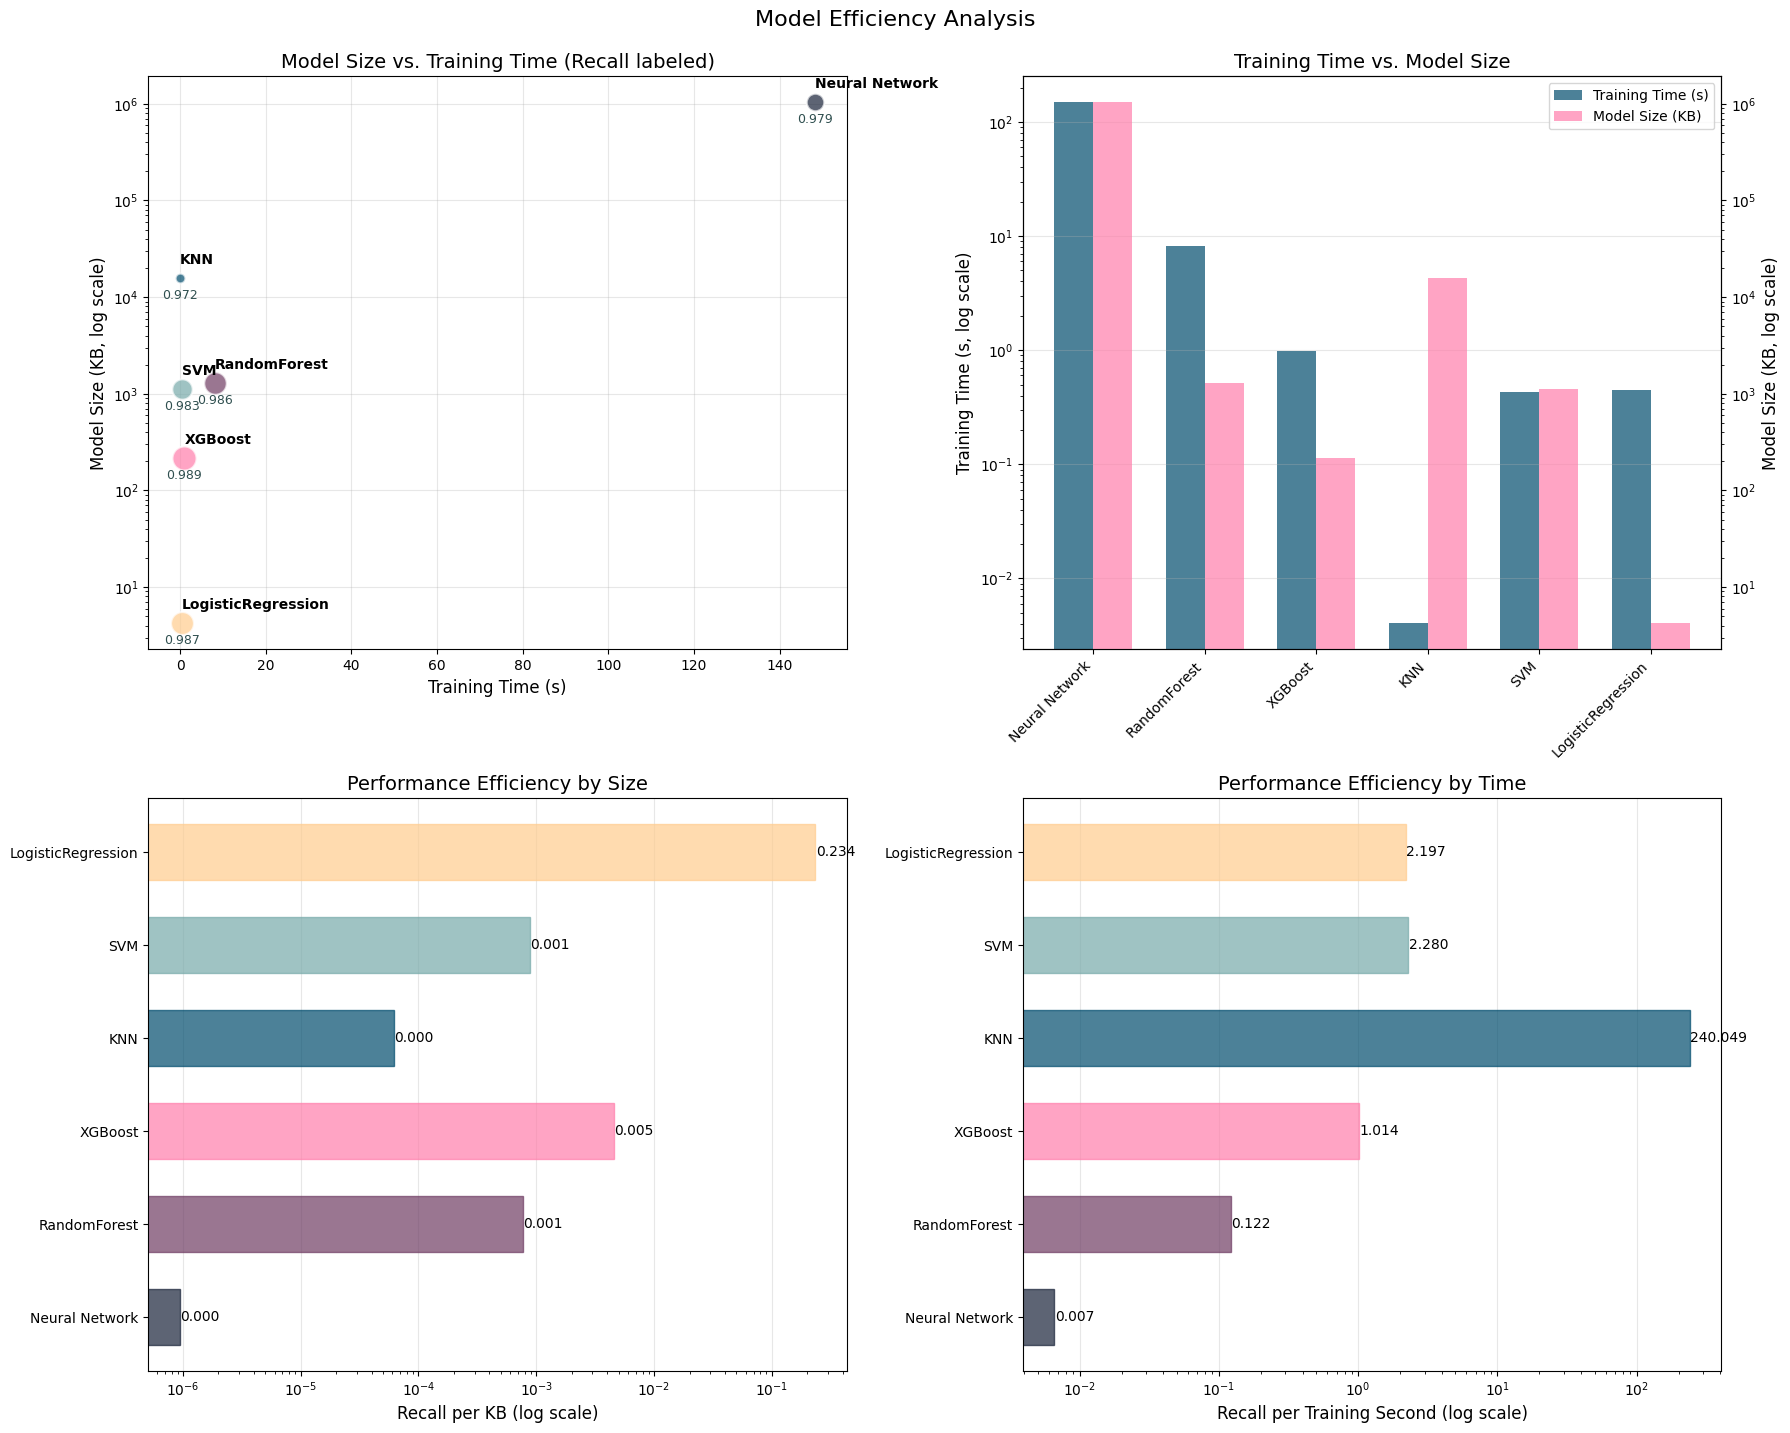

In [30]:
def plot_model_efficiency_comparison(
    results_nn, results_clf_dict, metrics=["pr_auc", "f1", "recall"], save_dir=None
):
    """
    Creates a comprehensive visualization showing model efficiency across size, training time,
    and performance metrics.
    """
    # Model names
    names = ["Neural Network"] + list(results_clf_dict.keys())

    colors = {
        "Neural Network": "#192339",
        "XGBoost": "#ff7eab",
        "RandomForest": "#6f3c63",
        "LogisticRegression": "#ffcc8e",
        "KNN": "#004c6d",
        "SVM": "#77aaaa",
    }

    # Get sizes (KB)
    nn_size = np.mean(results_nn.get("model_size", [0]))
    sizes = [nn_size]
    for res in results_clf_dict.values():
        sizes.append(np.mean(res.get("model_size", [0])))

    # Get training times
    nn_time = np.mean(results_nn.get("training_time", [0]))
    times = [nn_time]
    for res in results_clf_dict.values():
        times.append(np.mean(res.get("training_time", [0])))

    # Get performance metrics
    performance = {metric: [] for metric in metrics}
    for metric in metrics:
        performance[metric].append(results_nn[f"mean_{metric}"])
        for res in results_clf_dict.values():
            performance[metric].append(res[f"mean_{metric}"])

    # Create a figure with 2x2 grid
    fig = plt.figure(figsize=(18, 14))

    # 1. Combined scatter plot with text labels (upper left)
    ax1 = plt.subplot(2, 2, 1)
    primary_metric = metrics[0]

    # Calculate marker sizes proportionally but with a better range
    marker_sizes = [p * 500 for p in performance[primary_metric]]
    min_size, max_size = min(marker_sizes), max(marker_sizes)
    scaled_sizes = [
        50 + (s - min_size) * 250 / (max_size - min_size)
        if max_size > min_size
        else 100
        for s in marker_sizes
    ]

    # Plot with improved clarity
    for i, name in enumerate(names):
        ax1.scatter(
            times[i],
            sizes[i],
            s=scaled_sizes[i],
            color=colors.get(name, f"C{i}"),
            alpha=0.7,
            edgecolors="white",
            linewidth=1.5,
            zorder=3,
        )
        # Add model name above point
        ax1.annotate(
            name,
            (times[i], sizes[i]),
            xytext=(0, 10),
            textcoords="offset points",
            fontweight="bold",
            fontsize=10,
        )
        # Add metric value inside or below the marker
        ax1.annotate(
            f"{performance[primary_metric][i]:.3f}",
            (times[i], sizes[i]),
            xytext=(0, -15),
            textcoords="offset points",
            ha="center",
            fontsize=9,
            color="darkslategray",
        )

    ax1.set_xlabel("Training Time (s)", fontsize=12)
    ax1.set_ylabel("Model Size (KB)", fontsize=12)
    ax1.set_title(
        f"Model Size vs. Training Time ({primary_metric.capitalize()} labeled)",
        fontsize=14,
    )
    ax1.grid(True, alpha=0.3, zorder=0)
    ax1.set_axisbelow(True)

    # Use log scale only if size range is very large (>20x difference)
    size_ratio = max(sizes) / (min(sizes) or 0.001)  # Avoid division by zero
    if size_ratio > 20:
        ax1.set_yscale("log")
        ax1.set_ylabel("Model Size (KB, log scale)", fontsize=12)

    # 2. Grouped Bar Chart for Time & Size (upper right)
    ax2 = plt.subplot(2, 2, 2)
    x = np.arange(len(names))  # the label locations
    width = 0.35  # the width of the bars

    # Plot Training Time bars on the primary y-axis
    color_time = "#004c6d"
    rects1 = ax2.bar(
        x - width / 2,
        times,
        width,
        label="Training Time (s)",
        color=color_time,
        alpha=0.7,
    )
    ax2.set_ylabel("Training Time (s)", fontsize=12)
    ax2.tick_params(axis="y")
    ax2.set_xticks(x)
    ax2.set_xticklabels(names, rotation=45, ha="right")
    ax2.grid(True, alpha=0.3, axis="y")

    # Create a second y-axis for Model Size
    ax2b = ax2.twinx()
    color_size = "#ff7eab"
    rects2 = ax2b.bar(
        x + width / 2,
        sizes,
        width,
        label="Model Size (KB)",
        color=color_size,
        alpha=0.7,
    )
    ax2b.set_ylabel("Model Size (KB)", fontsize=12)
    ax2b.tick_params(axis="y")

    # Use log scale if ranges are very large
    time_ratio = max(times) / (min(times) or 1)
    if time_ratio > 20:
        ax2.set_yscale("log")
        ax2.set_ylabel("Training Time (s, log scale)", fontsize=12)

    size_ratio = max(sizes) / (min(sizes) or 1)
    if size_ratio > 20:
        ax2b.set_yscale("log")
        ax2b.set_ylabel("Model Size (KB, log scale)", fontsize=12)

    ax2.set_title("Training Time vs. Model Size", fontsize=14)
    ax2.legend(handles=[rects1, rects2])

    # 3. Performance per KB (lower left)
    ax3 = plt.subplot(2, 2, 3)
    metric = metrics[0]  # Use primary metric

    efficiency = [performance[metric][i] / sizes[i] for i in range(len(names))]
    y_pos = np.arange(len(names))

    bars = ax3.barh(y_pos, efficiency, height=0.6, alpha=0.7)

    efficiency_ratio = max(efficiency) / (min(efficiency) or 0.001)
    use_log_scale_eff = efficiency_ratio > 20

    # Color bars and add rounded labels
    for i, bar in enumerate(bars):
        bar.set_color(colors.get(names[i], f"C{i}"))
        ax3.text(
            bar.get_width() * 1.01,
            bar.get_y() + bar.get_height() / 2,
            f"{efficiency[i]:.3f}",
            va="center",
        )

    if use_log_scale_eff:
        ax3.set_xscale("log")
        ax3.set_xlabel(f"{metric.capitalize()} per KB (log scale)", fontsize=12)
    else:
        ax3.set_xlabel(f"{metric.capitalize()} per KB", fontsize=12)

    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(names)
    ax3.set_title("Performance Efficiency by Size", fontsize=14)
    ax3.grid(True, alpha=0.3, axis="x")
    ax3.set_axisbelow(True)

    # 4. Performance per second (lower right)
    ax4 = plt.subplot(2, 2, 4)
    efficiency = [performance[metric][i] / times[i] for i in range(len(names))]

    bars = ax4.barh(y_pos, efficiency, height=0.6, alpha=0.7)

    time_efficiency_ratio = max(efficiency) / (min(efficiency) or 0.001)
    use_log_scale_time = time_efficiency_ratio > 20

    # Color bars and add rounded labels
    for i, bar in enumerate(bars):
        bar.set_color(colors.get(names[i], f"C{i}"))
        ax4.text(
            bar.get_width() * 1.01,
            bar.get_y() + bar.get_height() / 2,
            f"{efficiency[i]:.3f}",
            va="center",
        )

    if use_log_scale_time:
        ax4.set_xscale("log")
        ax4.set_xlabel(
            f"{metric.capitalize()} per Training Second (log scale)", fontsize=12
        )
    else:
        ax4.set_xlabel(f"{metric.capitalize()} per Training Second", fontsize=12)

    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(names)
    ax4.set_title("Performance Efficiency by Time", fontsize=14)
    ax4.grid(True, alpha=0.3, axis="x")
    ax4.set_axisbelow(True)

    plt.tight_layout()
    plt.suptitle("Model Efficiency Analysis", fontsize=16, y=1.02)

    # Save figure if directory provided
    if save_dir:
        if isinstance(save_dir, str):
            save_dir = Path(save_dir)

        os.makedirs(save_dir, exist_ok=True)
        full_path = os.path.join(save_dir, "model_efficiency_analysis.svg")
        plt.savefig(full_path, format="svg", dpi=300, bbox_inches="tight")
        print(f"Efficiency analysis saved to {full_path}")

    plt.show()


plot_model_efficiency_comparison(
    nn_all_metrics,
    ml_all_metrics,
    metrics=["recall", "precision"],
    save_dir=PATH_TO_SAVE_DIR,
)

Loading latest model version: 20250702_162653
Loaded model 'XGBoost' from c:\Users\david\Desktop\Clase\TFG\tfg_24_25\model_artifacts\ml_models\20250702_162653
Successfully loaded XGBoost model
Feature importance plot saved to c:\Users\david\Desktop\Clase\TFG\tfg_24_25\plots\test\feature_importances\xgboost_feature_importance.svg


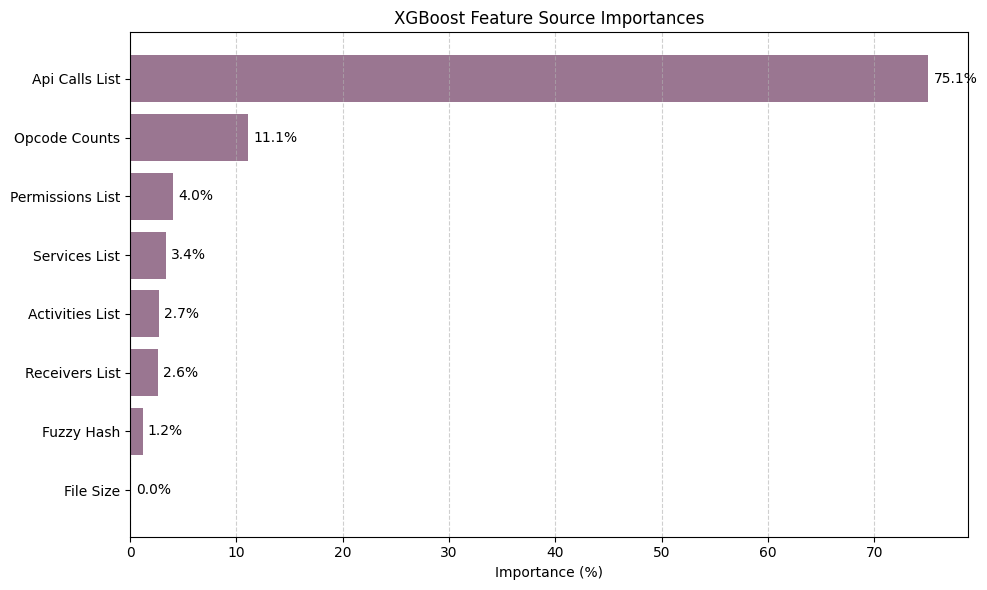

Loading latest model version: 20250702_162653
Loaded model 'RandomForest' from c:\Users\david\Desktop\Clase\TFG\tfg_24_25\model_artifacts\ml_models\20250702_162653
Successfully loaded RandomForest model
Feature importance plot saved to c:\Users\david\Desktop\Clase\TFG\tfg_24_25\plots\test\feature_importances\randomforest_feature_importance.svg


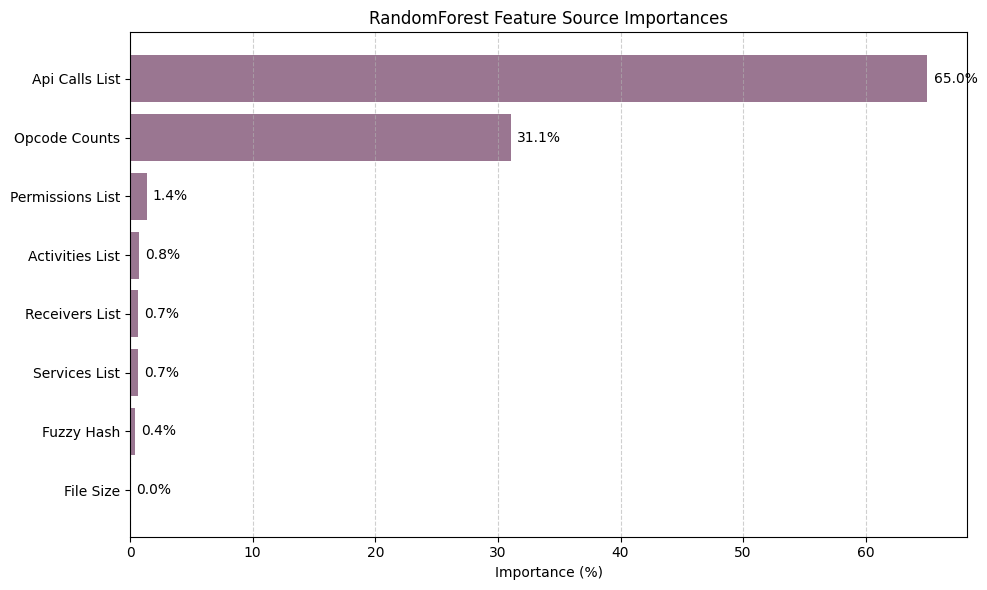

In [31]:
def plot_feature_importances(
    model_name, nn_metadata, scalar_cols, top_n=10, save_dir=None
):
    """
    Plots feature importances for tree-based models, correctly mapping them to the
    feature groups from the DebrimEmbedder.
    """
    try:
        model, _ = load_ml_model_from_version(model_name, version=ML_MODELS_VERSION, base_dir=PATH_TO_SAVE_ML_MODEL)
        print(f"Successfully loaded {model_name} model")
    except Exception as e:
        print(f"Error loading {model_name} model: {e}")
        return

    # Get importances from the classical model
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    else:
        print(f"No feature importance method known for {model_name}")
        return

    # --- Get embedding structure from NN metadata ---
    try:
        model_arch = nn_metadata["model_architecture"]
        hyperparams = nn_metadata["hyperparameters"]
        embedding_dim = hyperparams["embedding_dim"]

        # The order of concatenation in the embedder
        sequence_cols = model_arch.get("sequence_cols", [])
        char_cols = model_arch.get("char_cols", [])
        vector_cols = model_arch.get("vector_cols", [])

        embedding_groups = sequence_cols + char_cols + vector_cols
        all_feature_sources = embedding_groups + scalar_cols

        if not all_feature_sources:
            print("No feature sources found in NN metadata or provided.")
            return

        # Verify that the total dimension matches the number of features in the classical model
        expected_features = (len(embedding_groups) * embedding_dim) + len(scalar_cols)
        actual_features = len(importances)
        if expected_features != actual_features:
            print(
                f"Warning: Mismatch between expected features from NN metadata ({expected_features}) and actual features in ML model ({actual_features})."
            )
            # This can happen if the model was trained on embeddings from a different NN architecture.
            # Proceeding, but the results may be misinterpreted.

    except KeyError as e:
        print(
            f"Error: Missing key {e} in NN metadata. Cannot determine feature structure."
        )
        return

    # --- Aggregate importances by feature group ---
    feature_group_importance = {}
    current_idx = 0

    # 1. Process aggregated embedding groups
    for group_name in embedding_groups:
        end_idx = current_idx + embedding_dim
        if end_idx > len(importances):
            print(
                f"Warning: Ran out of importance values while processing group '{group_name}'. Stopping."
            )
            break
        group_importance = np.sum(importances[current_idx:end_idx])
        feature_group_importance[group_name] = group_importance
        current_idx = end_idx

    # 2. Process individual scalar features
    for scalar_name in scalar_cols:
        if current_idx >= len(importances):
            print(
                f"Warning: Ran out of importance values while processing scalar '{scalar_name}'. Stopping."
            )
            break
        scalar_importance = importances[current_idx]
        feature_group_importance[scalar_name] = scalar_importance
        current_idx += 1

    # --- Process for plotting ---
    readable_names = {
        name: name.replace("_", " ").title() for name in feature_group_importance.keys()
    }
    feature_names = list(feature_group_importance.keys())
    importance_values = np.array(list(feature_group_importance.values()))

    # Normalize to percentages
    total_importance = importance_values.sum()
    if total_importance > 0:
        importance_values = 100 * importance_values / total_importance
    else:
        print("Warning: Total feature importance is zero. Cannot plot.")
        return

    # Sort and select top features
    idx = np.argsort(importance_values)[::-1][:top_n]
    sorted_names = np.array(feature_names)[idx]
    sorted_importances = importance_values[idx]
    display_names = [readable_names[name] for name in sorted_names]

    # --- Create plot ---
    plt.figure(figsize=(10, 6))
    bars = plt.barh(display_names, sorted_importances, alpha=0.7, color="#6f3c63")

    # Add percentage labels
    for bar, value in zip(bars, sorted_importances):
        plt.text(
            value + 0.5,
            bar.get_y() + bar.get_height() / 2,
            f"{value:.1f}%",
            va="center",
        )

    plt.xlabel("Importance (%)")
    plt.title(f"{model_name} Feature Source Importances")
    plt.gca().invert_yaxis()
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Save if directory provided
    if save_dir:
        if isinstance(save_dir, str):
            save_dir = Path(save_dir)

        base_dir = os.path.join(save_dir, "feature_importances")
        os.makedirs(base_dir, exist_ok=True)

        model_filename = model_name.replace(" ", "_").lower()
        full_path = os.path.join(base_dir, f"{model_filename}_feature_importance.svg")

        plt.savefig(full_path, format="svg", dpi=300, bbox_inches="tight")
        print(f"Feature importance plot saved to {full_path}")


plot_feature_importances(
    "XGBoost", nn_metadata, scalar_cols=SCALAR_COLS, top_n=10, save_dir=PATH_TO_SAVE_DIR
)
plt.show()

plot_feature_importances(
    "RandomForest",
    nn_metadata,
    scalar_cols=SCALAR_COLS,
    top_n=10,
    save_dir=PATH_TO_SAVE_DIR,
)
plt.show()

Loss curves saved to c:\Users\david\Desktop\Clase\TFG\tfg_24_25\plots\test\training_curves\nn_loss_curves.svg


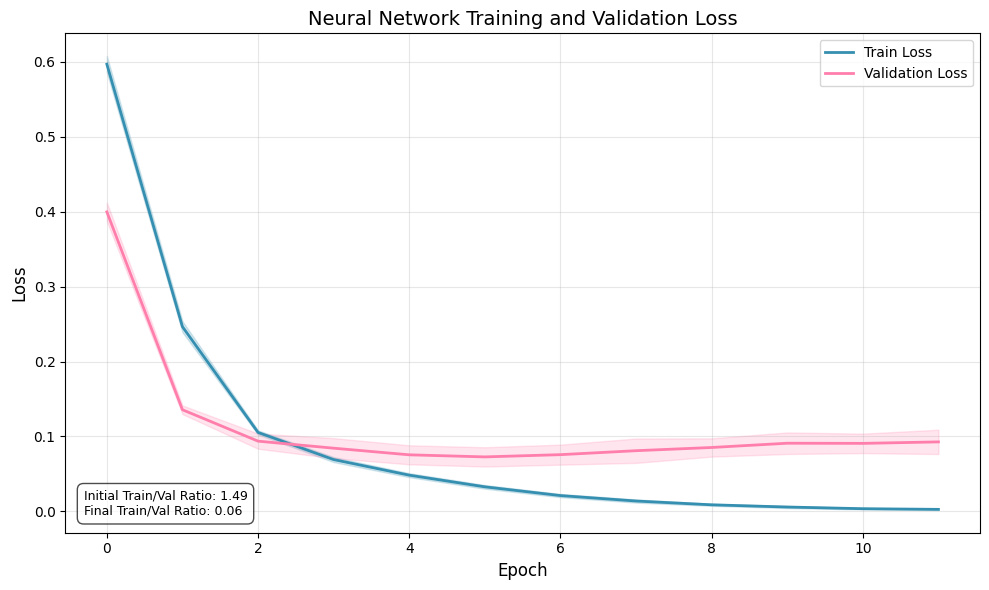

In [32]:
def plot_loss_curves(results_nn, save_dir: Path | str | None = None):
    """
    Plots train/val loss vs. epochs with variance shading.
    Handles varying epoch lengths due to early stopping.

    Parameters
    ----------
    results_nn : dict
        Dictionary containing training metrics with keys 'train_losses' and 'val_losses'
    save_dir : Path or str, optional
        Directory to save the visualization
    """
    colors = {"train": "#358fb0", "val": "#ff7eab"}

    # Determine maximum number of epochs across all folds
    max_epochs = max(len(losses) for losses in results_nn["train_losses"])

    # Pad each fold's losses with np.nan to match max_epochs
    padded_train = [
        np.pad(losses, (0, max_epochs - len(losses)), constant_values=np.nan)
        for losses in results_nn["train_losses"]
    ]
    padded_val = [
        np.pad(losses, (0, max_epochs - len(losses)), constant_values=np.nan)
        for losses in results_nn["val_losses"]
    ]

    train_arr = np.array(padded_train)
    val_arr = np.array(padded_val)

    train_mean = np.nanmean(train_arr, axis=0)
    train_std = np.nanstd(train_arr, axis=0)
    val_mean = np.nanmean(val_arr, axis=0)
    val_std = np.nanstd(val_arr, axis=0)

    # Create figure
    plt.figure(figsize=(10, 6))

    # Plot training loss
    plt.plot(
        range(max_epochs),
        train_mean,
        color=colors["train"],
        label="Train Loss",
        linewidth=2,
    )
    plt.fill_between(
        range(max_epochs),
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.2,
        color=colors["train"],
    )

    # Plot validation loss
    plt.plot(
        range(max_epochs),
        val_mean,
        color=colors["val"],
        label="Validation Loss",
        linewidth=2,
    )
    plt.fill_between(
        range(max_epochs),
        val_mean - val_std,
        val_mean + val_std,
        alpha=0.2,
        color=colors["val"],
    )

    # Add early stopping visualization
    avg_early_stop = int(
        np.mean([len(losses) for losses in results_nn["train_losses"]])
    )

    # Add annotations about convergence
    plt.text(
        0.02,
        0.03,
        f"Initial Train/Val Ratio: {train_mean[0] / val_mean[0]:.2f}\nFinal Train/Val Ratio: {train_mean[avg_early_stop - 1] / val_mean[avg_early_stop - 1]:.2f}",
        transform=plt.gca().transAxes,
        fontsize=9,
        va="bottom",
        ha="left",
        bbox=dict(facecolor="white", alpha=0.7, boxstyle="round,pad=0.5"),
    )

    legend_elements = [
        Line2D([0], [0], color=colors["train"], lw=2, label="Train Loss"),
        Line2D([0], [0], color=colors["val"], lw=2, label="Validation Loss"),
    ]

    # Formatting
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Neural Network Training and Validation Loss", fontsize=14)
    plt.legend(loc="best", handles=legend_elements)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save figure if directory is provided
    if save_dir:
        if isinstance(save_dir, str):
            save_dir = Path(save_dir)

        base_dir = os.path.join(save_dir, "training_curves")
        os.makedirs(base_dir, exist_ok=True)
        full_path = os.path.join(base_dir, "nn_loss_curves.svg")

        plt.savefig(full_path, format="svg", dpi=300, bbox_inches="tight")
        print(f"Loss curves saved to {full_path}")

    return plt


plot_loss_curves(nn_all_metrics, save_dir=PATH_TO_SAVE_DIR)
plt.show()

Convergence analysis saved to c:\Users\david\Desktop\Clase\TFG\tfg_24_25\plots\test\training_curves\training_convergence_analysis.svg


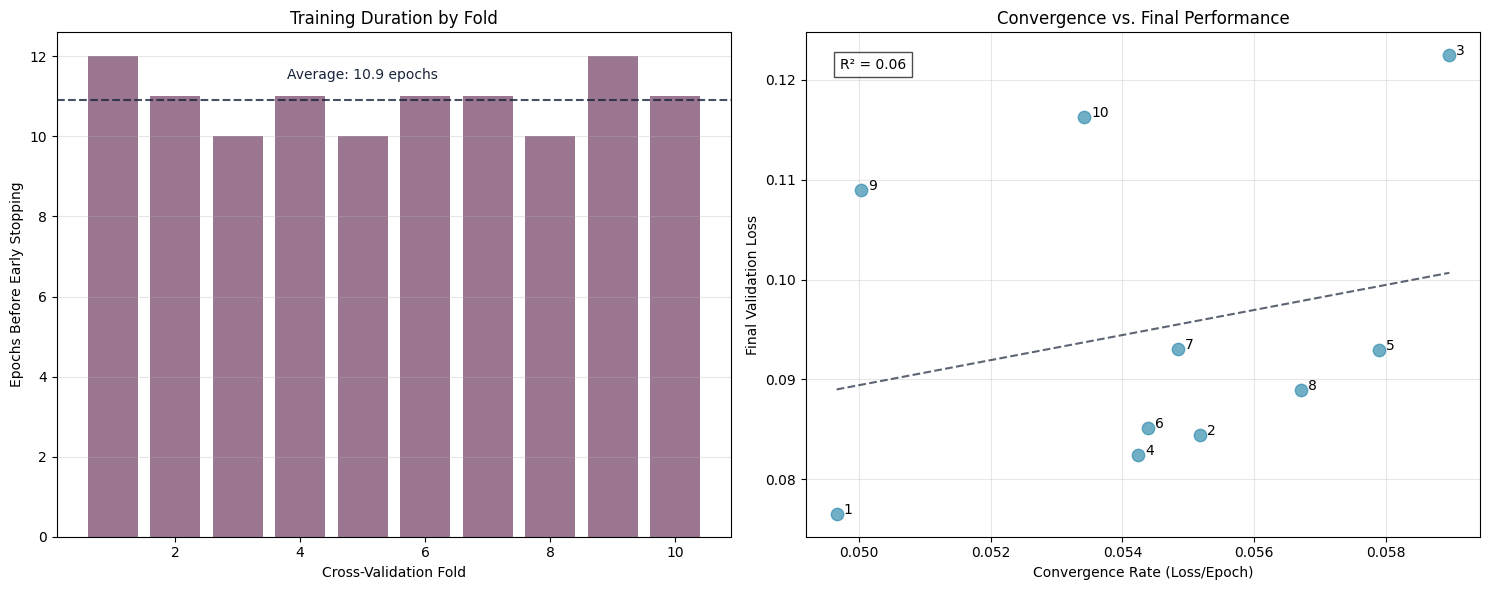

In [33]:
def plot_learning_rate_effect(results_nn, save_dir: Path | str | None = None):
    """
    Visualizes the effect of early stopping and learning rates across folds.
    """
    colors = {
        "bars": "#6f3c63",
        "dots": "#358db0",
        "lines": "#192339",
    }

    # Get lengths of each fold's training (epochs before early stopping)
    fold_lengths = [len(losses) for losses in results_nn["train_losses"]]
    fold_stop_losses = [val_losses[-1] for val_losses in results_nn["val_losses"]]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # First subplot: Epochs completed per fold
    ax1.bar(
        range(1, len(fold_lengths) + 1), fold_lengths, color=colors["bars"], alpha=0.7
    )
    ax1.axhline(
        y=np.mean(fold_lengths),
        color=colors["lines"],
        linestyle="--",
        lw=1.5,
        alpha=0.8,
    )
    ax1.text(
        len(fold_lengths) * 0.5,
        np.mean(fold_lengths) * 1.05,
        f"Average: {np.mean(fold_lengths):.1f} epochs",
        ha="center",
        color=colors["lines"],
        fontsize=10,
    )
    ax1.set_xlabel("Cross-Validation Fold")
    ax1.set_ylabel("Epochs Before Early Stopping")
    ax1.set_title("Training Duration by Fold")
    ax1.grid(True, alpha=0.3, axis="y")

    # Second subplot: Convergence visualization
    for i, (train_losses, val_losses) in enumerate(
        zip(results_nn["train_losses"], results_nn["val_losses"])
    ):
        # Calculate convergence rate (average loss decrease per epoch)
        if len(train_losses) > 1:
            conv_rate = (train_losses[0] - train_losses[-1]) / len(train_losses)
        else:
            conv_rate = 0

        # Plot scatter points - x: convergence rate, y: final validation loss
        ax2.scatter(
            conv_rate,
            val_losses[-1],
            s=80,
            alpha=0.7,
            color=colors["dots"],
            label=f"Fold {i + 1}" if i == 0 else "",
        )
        ax2.annotate(
            f"{i + 1}",
            (conv_rate, val_losses[-1]),
            xytext=(5, 0),
            textcoords="offset points",
        )

    # Add trend line
    if len(results_nn["train_losses"]) > 2:
        conv_rates = [
            (t[0] - t[-1]) / len(t) for t in results_nn["train_losses"] if len(t) > 1
        ]
        final_val_losses = [v[-1] for v in results_nn["val_losses"]]

        if len(conv_rates) > 1:
            from scipy.stats import linregress

            slope, intercept, r_value, _, _ = linregress(conv_rates, final_val_losses)
            x_line = np.linspace(min(conv_rates), max(conv_rates), 100)
            ax2.plot(
                x_line,
                slope * x_line + intercept,
                "--",
                color=colors["lines"],
                alpha=0.7,
            )
            ax2.text(
                0.05,
                0.95,
                f"R² = {r_value**2:.2f}",
                transform=ax2.transAxes,
                va="top",
                bbox=dict(facecolor="white", alpha=0.7),
            )

    ax2.set_xlabel("Convergence Rate (Loss/Epoch)")
    ax2.set_ylabel("Final Validation Loss")
    ax2.set_title("Convergence vs. Final Performance")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save figure if directory is provided
    if save_dir:
        if isinstance(save_dir, str):
            save_dir = Path(save_dir)

        base_dir = os.path.join(save_dir, "training_curves")
        os.makedirs(base_dir, exist_ok=True)
        full_path = os.path.join(base_dir, "training_convergence_analysis.svg")

        plt.savefig(full_path, format="svg", dpi=300, bbox_inches="tight")
        print(f"Convergence analysis saved to {full_path}")

    return plt


plot_learning_rate_effect(nn_all_metrics, save_dir=PATH_TO_SAVE_DIR)
plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_6524\1808300705.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


Confusion matrices plot saved to c:\Users\david\Desktop\Clase\TFG\tfg_24_25\plots\test\confusion_matrices.svg


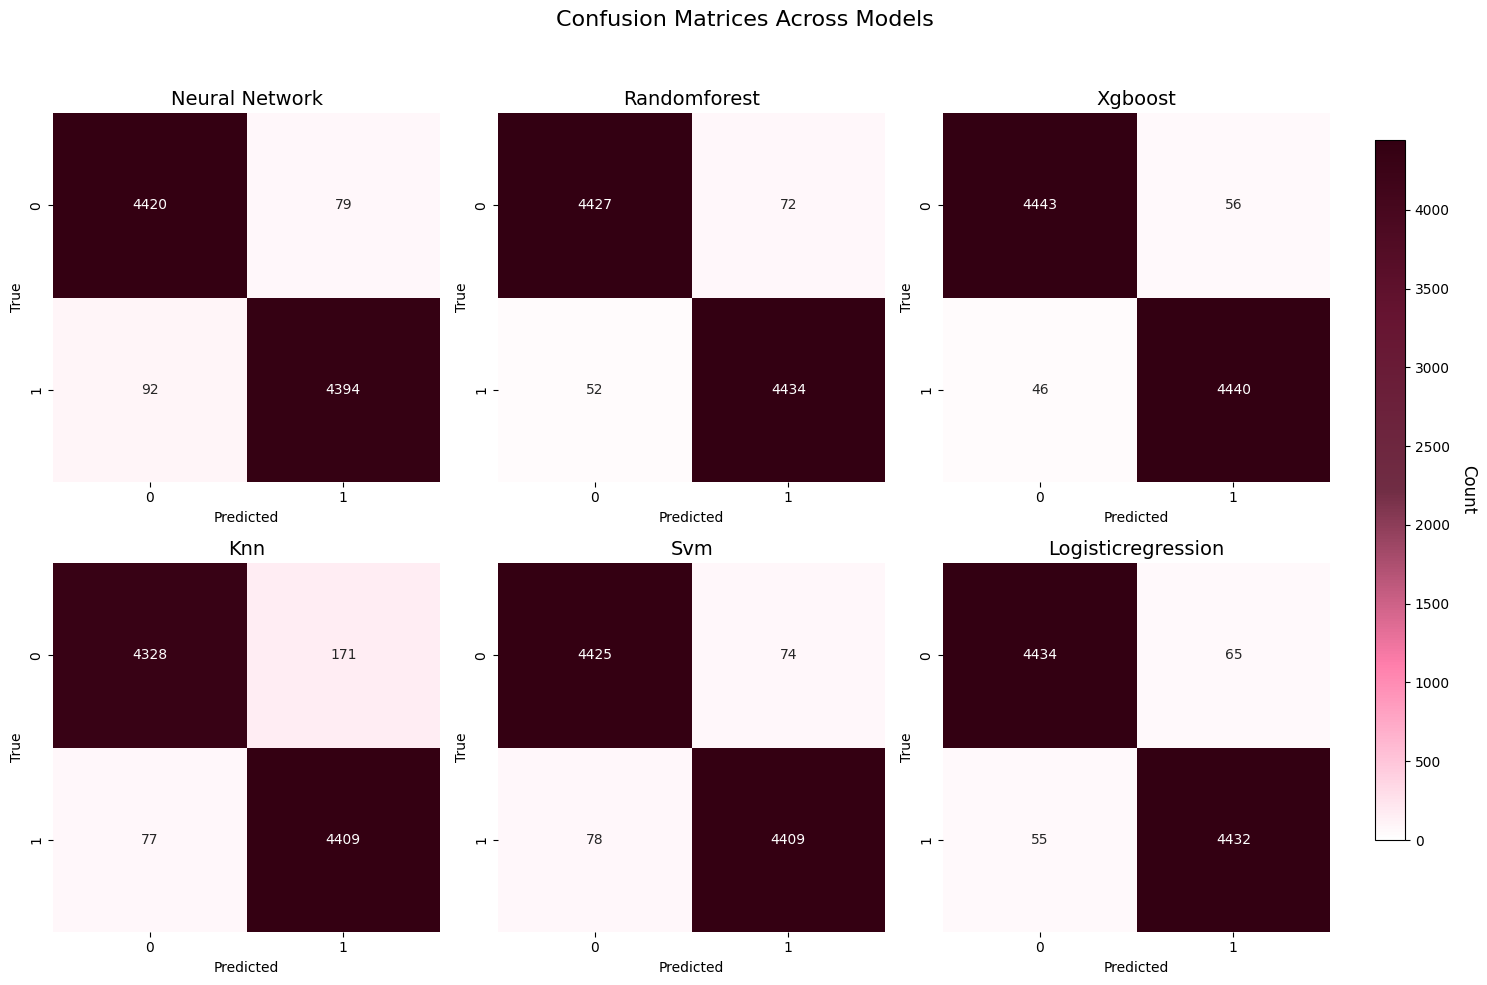

In [34]:
# Visualize confusion matrices for all models
def plot_confusion_matrices(
    nn_results, classic_results, save_dir: Path | str | None = None
):
    from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.cm import ScalarMappable

    # Convert lists to NumPy arrays and compute mean confusion matrix
    nn_cms = np.array(nn_results["conf_matrices"])
    nn_cm_mean = np.mean(nn_cms, axis=0).astype(int)

    # Collect all confusion matrices (including NN) for scaling and plotting
    all_models = [("Neural Network", nn_cm_mean)]
    for name, results in classic_results.items():
        model_cms = np.array(results["conf_matrices"])
        model_cm_mean = np.mean(model_cms, axis=0).astype(int)
        all_models.append((name.replace("_", " ").title(), model_cm_mean))

    total_models = len(all_models)

    # Calculate grid layout (rows x cols) to fit all subplots
    n_cols = math.ceil(math.sqrt(total_models))
    n_rows = math.ceil(total_models / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten() if total_models > 1 else [axes]

    # Choose colormap
    colors = ["white", "#FF7EAB", "#702D44", "#661431", "#330012"]  # pink gradient
    # colors = ["white", "#6F3C63", "#993D84", "#661453", "#330027"]  # purple gradient
    # colors = ["white", "#AADDDD", "#77AAAA", "#447777", "#114444"]  # teal gradient
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)
    # cmap = sns.color_palette(["white", "#6f3c63", "#192339"], as_cmap=True)
    # 💡 To use a different color gradient, change 'Blues' above to any valid seaborn/matplotlib colormap string
    # Example: cmap = sns.color_palette("viridis", as_cmap=True)

    # Get the global maximum value for consistent color scaling
    max_val = max(cm.max() for _, cm in all_models)

    # Plot each confusion matrix
    for ax, (title, cm) in zip(axes, all_models):
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap=cmap,
            vmin=0,
            vmax=max_val,
            ax=ax,
            cbar=False,
        )
        ax.set_title(title, fontsize=14)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

    # Hide unused subplots
    for i in range(total_models, len(axes)):
        axes[i].axis("off")

    # Add a single shared colorbar
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    mappable = ScalarMappable(cmap=cmap)
    mappable.set_array(np.linspace(0, max_val, 100))
    cbar = fig.colorbar(mappable, cax=cbar_ax)
    cbar.set_label("Count", rotation=270, labelpad=20, fontsize=12)

    # Final layout adjustments
    plt.suptitle("Confusion Matrices Across Models", fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])

    # Save figure if directory is provided
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        full_path = os.path.join(save_dir, "confusion_matrices.svg")
        plt.savefig(full_path, format="svg", dpi=300, bbox_inches="tight")
        print(f"Confusion matrices plot saved to {full_path}")

    plt.show()


plot_confusion_matrices(nn_all_metrics, ml_all_metrics, save_dir=PATH_TO_SAVE_DIR)